# Cluster analysis based on naturalistic stimuli responses

This notebook illustrates how to cluster the models of an ensemble after nonlinear dimensionality reduction on their predicted responses to naturalistic stimuli. This can be done for any cell type. Here we provide a detailed example focusing on clustering based on T4c responses.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [1]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [2]:
# @markdown **Install Flyvis**
if IN_COLAB:
    !git clone https://github.com/TuragaLab/flyvis.git
    %cd /content/flyvis
    !pip install -e .[examples]

# Naturalistic stimuli dataset (Sintel)
We load the dataset with our custom augmentations. The dataset contains movie sequences from the publicly available computer-animated movie Sintel rendered to the hexagonal lattice structure of the fly eye. For a more detailed introduction to the dataset class and parameters see the notebook on the optic flow task.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch


import flyvis
from flyvis.datasets.sintel import AugmentedSintel
from flyvis.analysis.animations import HexScatter

In [4]:
dt = 1 / 100  # can be changed for other temporal resolutions
dataset = AugmentedSintel(
    tasks=["lum"],
    interpolate=False,
    boxfilter={'extent': 15, 'kernel_size': 13},
    temporal_split=True,
    dt=dt,
)

[2024-12-08 19:36:52] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [5]:
# view stimulus parameters
dataset.arg_df

,name,original_index,vertical_split_index,temporal_split_index,frames,flip_ax,n_rot
0,sequence_00_alley_1_split_00,0,0,0,19,0,0
1,sequence_00_alley_1_split_00,0,0,0,19,0,1
2,sequence_00_alley_1_split_00,0,0,0,19,0,2
3,sequence_00_alley_1_split_00,0,0,0,19,0,3
4,sequence_00_alley_1_split_00,0,0,0,19,0,4
...,...,...,...,...,...,...,...
2263,sequence_22_temple_3_split_02,22,68,188,19,1,1
2264,sequence_22_temple_3_split_02,22,68,188,19,1,2
2265,sequence_22_temple_3_split_02,22,68,188,19,1,3
2266,sequence_22_temple_3_split_02,22,68,188,19,1,4


In [6]:
sequence = dataset[0]["lum"]

In [7]:
# one sequence contains 80 frames with 721 hexals each
sequence.shape

torch.Size([80, 1, 721])

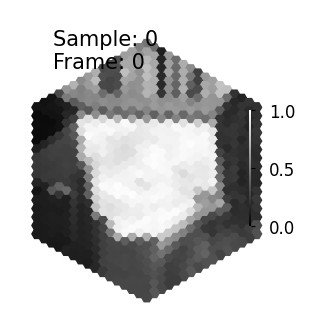

In [8]:
animation = HexScatter(sequence[None], vmin=0, vmax=1)
animation.animate_in_notebook(frames=np.arange(5))

# Ensemble responses to naturalistic sequences
We compute the responses of all models in the stored ensemble to the augmented Sintel dataset.

In [9]:
# We load the ensemble trained on the optic flow task
ensemble = flyvis.EnsembleView("flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-12-08 19:37:13] ensemble:166 Loaded 50 networks.


We use `ensemble.naturalistic_stimuli_responses` to return responses of all networks within the ensemble.

In [10]:
# alternatively, specify indices of sequences to load
# stims_and_resps = ensemble.naturalistic_stimuli_responses(indices=np.arange(5))
# or load all sequences
stims_and_resps = ensemble.naturalistic_stimuli_responses()

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/86b080e815ea9ec928a380df83961c32/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/b59b4553d26177882434e7a38fcb1f36/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/34edb9af3c92827b50340e6903d4f04c/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/6d4092c24a8f5e5ea8a651c5d62a4cb1/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/f60dd61be87e6f68b35174932ea805a3/output.h5
/groups/turaga/home/lappalainenj/FlyVis/priva

In [11]:
# recommended to only run with precomputed responses using the pipeline manager script,
# see example_submissions.sh in the repository
# norm = ensemble.responses_norm()
# responses = stims_and_resps["responses"] / (norm + 1e-6)
responses = stims_and_resps["responses"]

Text(0.5, 1.0, 'T4c responses to naturalistic stimuli')

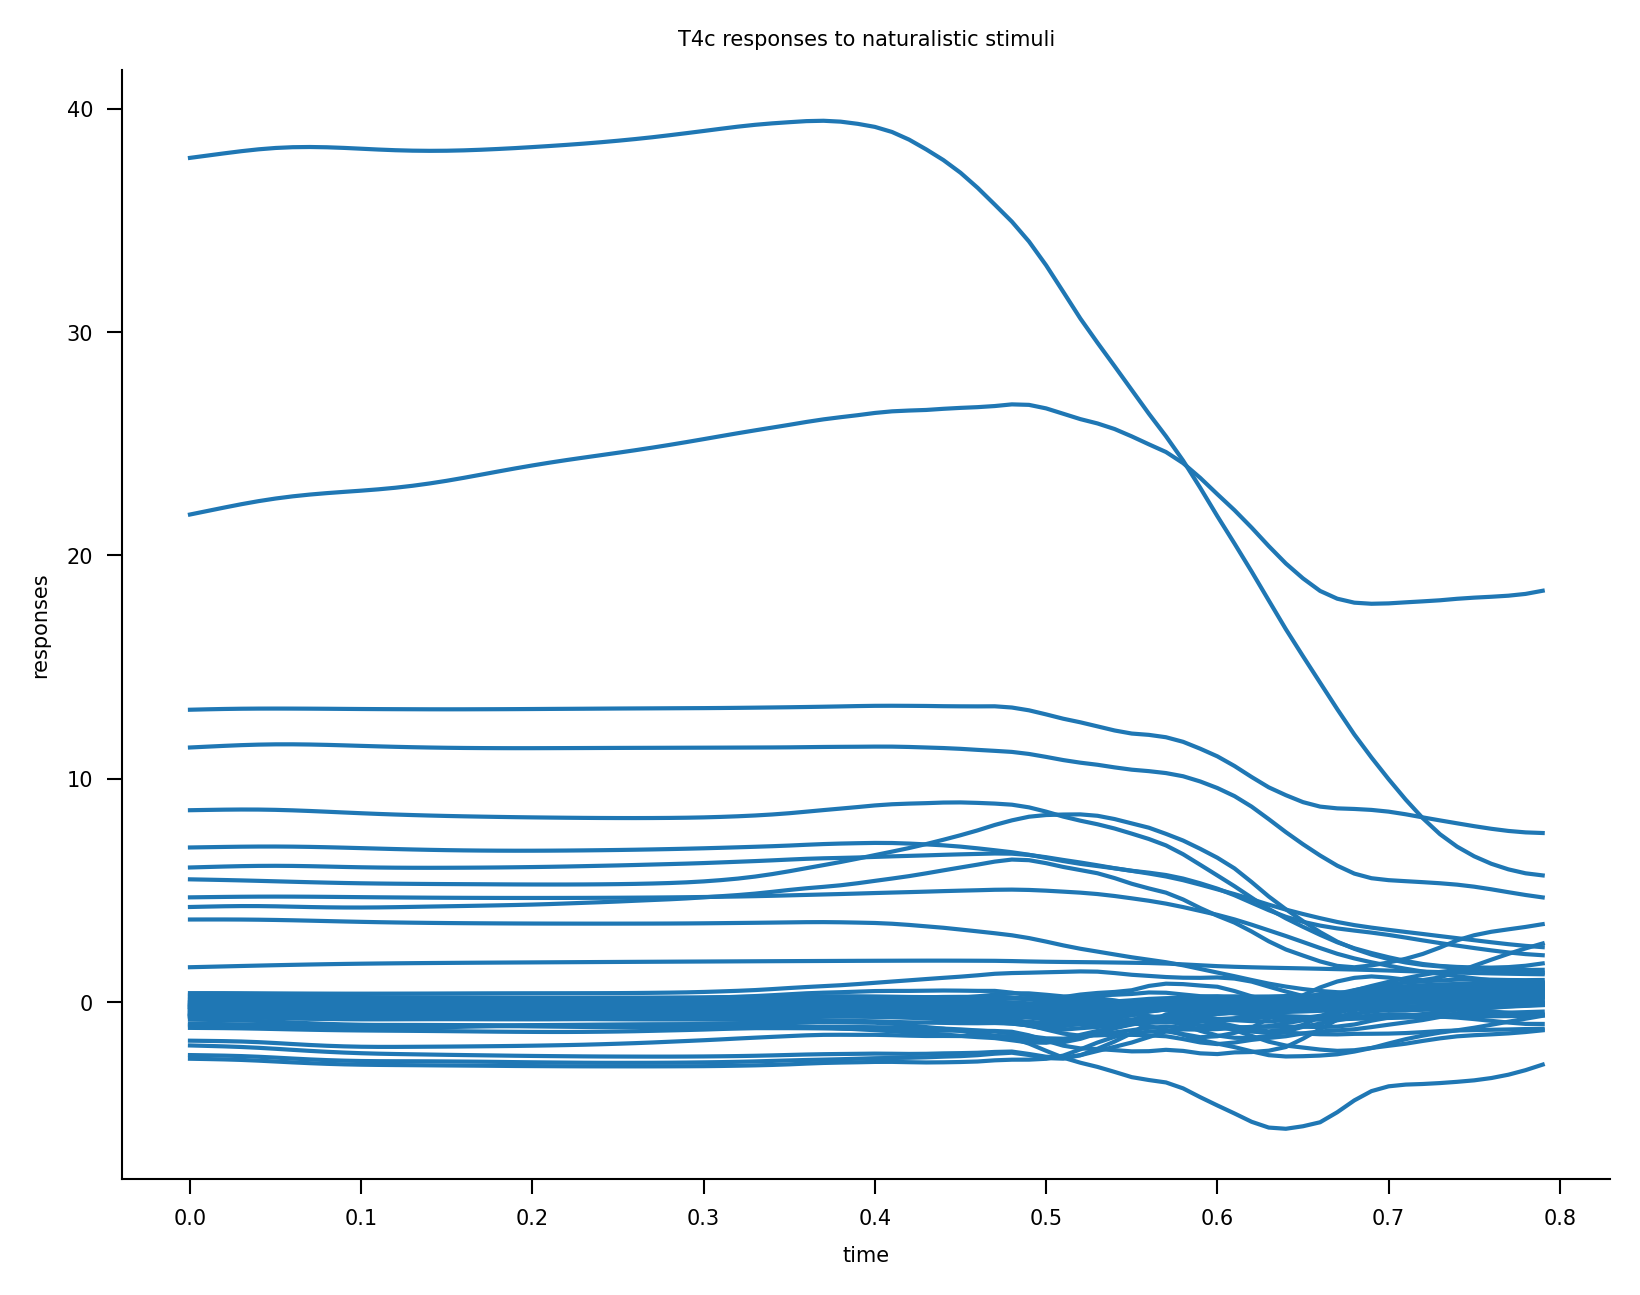

In [12]:
responses.custom.where(cell_type="T4c", u=0, v=0, sample=0).custom.plot_traces(
    x="time", plot_kwargs=dict(color="tab:blue", add_legend=False)
)
ax = plt.gca()
ax.set_title("T4c responses to naturalistic stimuli")

We see that the across models of the ensemble the predictions for T4c vary. Our goal is to understand the underlying structure in those variations.

## Nonlinear dimensionality reduction (UMAP) and Gaussian Mixtures

In [13]:
from flyvis.analysis.clustering import EnsembleEmbedding, get_cluster_to_indices
from flyvis.utils.activity_utils import CentralActivity

In [14]:
# specify parameters for umap embedding

embedding_kwargs = {
    "min_dist": 0.105,
    "spread": 9.0,
    "n_neighbors": 5,
    "random_state": 42,
    "n_epochs": 1500,
}

We compute the UMAP embedding of the ensemble based on the T4c responses of the single models to the single sequence for illustration.

In [15]:
central_responses = CentralActivity(responses.values, connectome=ensemble.connectome)

In [16]:
embedding = EnsembleEmbedding(central_responses)
t4c_embedding = embedding("T4c", embedding_kwargs=embedding_kwargs)

[2024-12-08 19:37:34] clustering:482 reshaped X from (50, 2268, 80) to (50, 181440)
/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [17]:
task_error = ensemble.task_error()

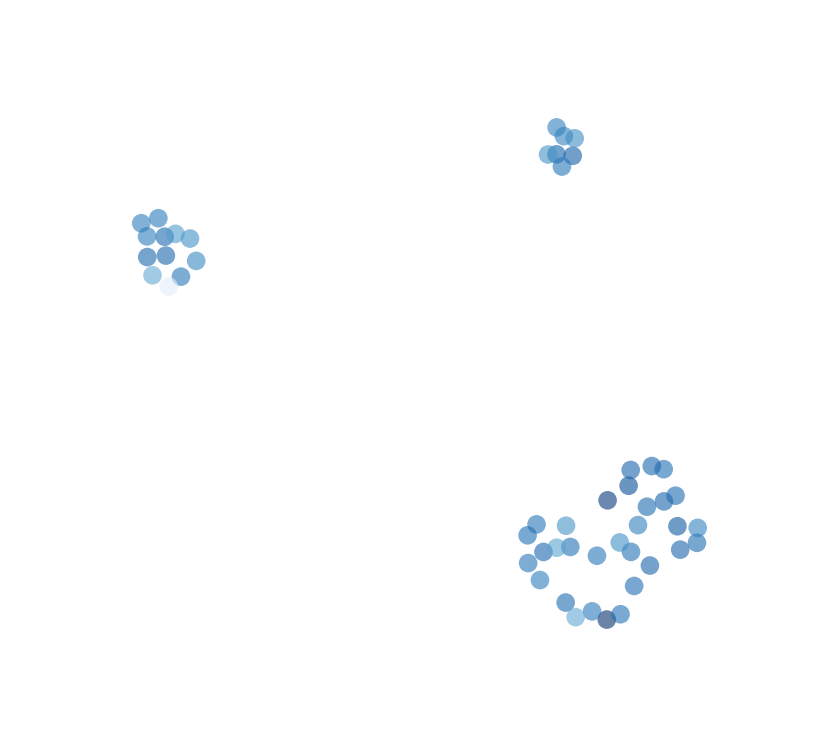

In [18]:
embeddingplot = t4c_embedding.plot(colors=task_error.colors)

Each of these scatterpoints in 2d represents a single time series plotted above.

We fit a Gaussian Mixture of 2 to 5 components to this embedding to label the clusters. We select the final number of Gaussian Mixture components that minimize the Bayesian Information Criterion (BIC).

In [19]:
# specifiy parameters for Gaussian Mixture

gm_kwargs = {
    "range_n_clusters": [1, 2, 3, 4, 5],
    "n_init": 100,
    "max_iter": 1000,
    "random_state": 42,
    "tol": 0.001,
}

In [20]:
gm_clustering = t4c_embedding.cluster.gaussian_mixture(**gm_kwargs)

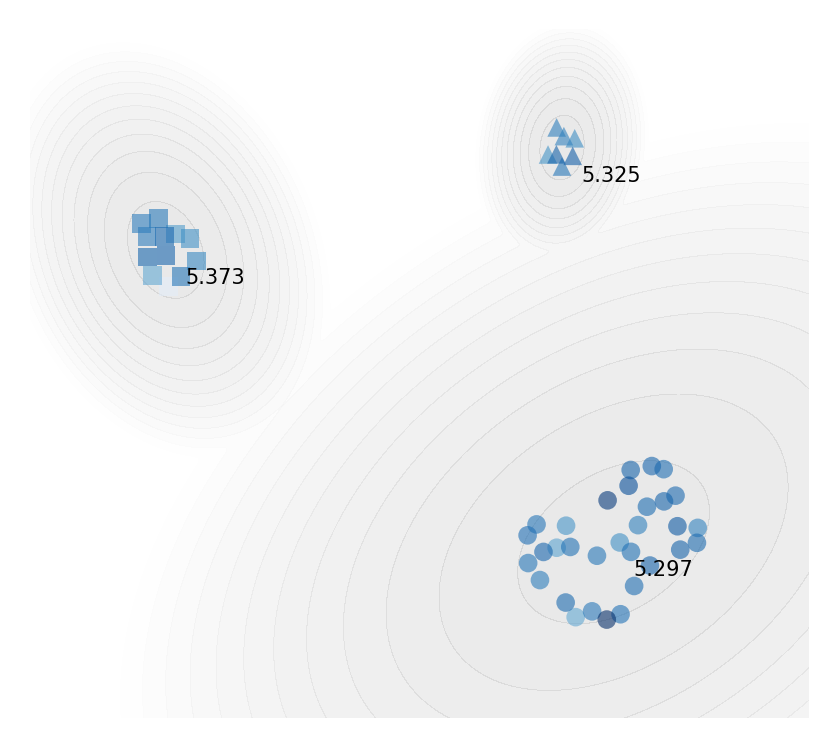

In [21]:
embeddingplot = gm_clustering.plot(task_error=task_error.values, colors=task_error.colors)

We can use the labels to disambiguate the time series data that we plotted above. We expect that these labels aggregate similar time series together and different time series separately.

In [22]:
import matplotlib.colors as mcolors

In [23]:
cluster_to_indices = get_cluster_to_indices(
    embeddingplot.cluster.embedding.mask,
    embeddingplot.cluster.labels,
    ensemble.task_error(),
)

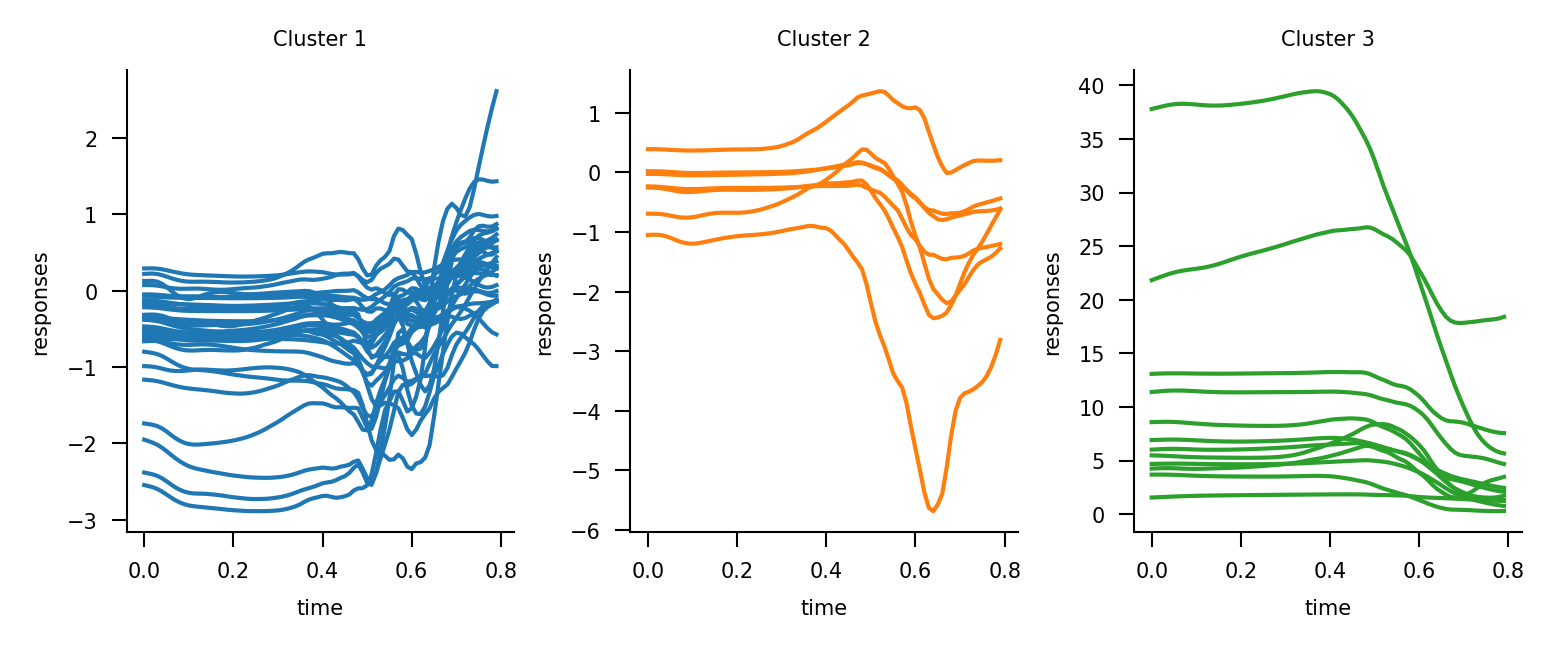

In [24]:
fig, axes = plt.subplots(1, len(cluster_to_indices), figsize=(6, 2))
colors = {i: color for i, color in enumerate(mcolors.TABLEAU_COLORS.values())}
for cluster_id, indices in cluster_to_indices.items():
    responses.sel(network_id=indices, sample=[0]).custom.where(
        cell_type="T4c"
    ).custom.plot_traces(
        x="time",
        plot_kwargs=dict(color=colors[cluster_id], add_legend=False, ax=axes[cluster_id]),
    )
    axes[cluster_id].set_title(f"Cluster {cluster_id + 1}")
plt.subplots_adjust(wspace=0.3)

The clustering has led us to three qualitatively distinct predictions from the ensemble for this cell and sequence. This is a first lead for an underlying structure in these predictions. We will get an even better estimate once we use more sequences for the clustering.

# Using the clustering to discover tuning predictions in responses to simple stimuli

We expect that the clustering based on naturalistic stimuli will also disambiguate the different tuning predictions from different models for simple stimuli.

In [25]:
cluster_to_indices = get_cluster_to_indices(
    embeddingplot.cluster.embedding.mask,
    embeddingplot.cluster.labels,
    ensemble.task_error(),
)

In [26]:
# define different colormaps for clusters
cluster_colors = {}
CMAPS = ["Blues_r", "Reds_r", "Greens_r", "Oranges_r", "Purples_r"]

for cluster_id in cluster_to_indices:
    cluster_colors[cluster_id] = ensemble.task_error(cmap=CMAPS[cluster_id]).colors

## Clustered voltage responses to moving edges

In [27]:
from flyvis.analysis.moving_bar_responses import plot_angular_tuning
from flyvis.analysis.visualization import plt_utils
from flyvis.utils.color_utils import color_to_cmap

In [28]:
stims_and_resps_moving_edge = ensemble.moving_edge_responses()

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/e236e47b9a57dc6d7b692906aca84495/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/2a1519d1c3b8bf0d0776e8ff2618353d/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/787654b3c56e4015939e72adfa768448/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/9d4697cbfdcda0d4b910d26a3f48a2dd/output.h5
/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/546ffb3b9036631dbb8bc4f2d8c3639f/output.h5
/groups/turaga/home/lappalainenj/FlyVis/priva

In [29]:
# invariant to different magnitudes of responses, only to assess direction tuning
stims_and_resps_moving_edge["responses"] /= np.abs(
    stims_and_resps_moving_edge["responses"]
).max(dim=("sample", "frame"))

# relative to the norm of the responses to naturalistic stimuli (used for averaging)
# stims_and_resps_moving_edge['responses'] /= (norm + 1e-6)

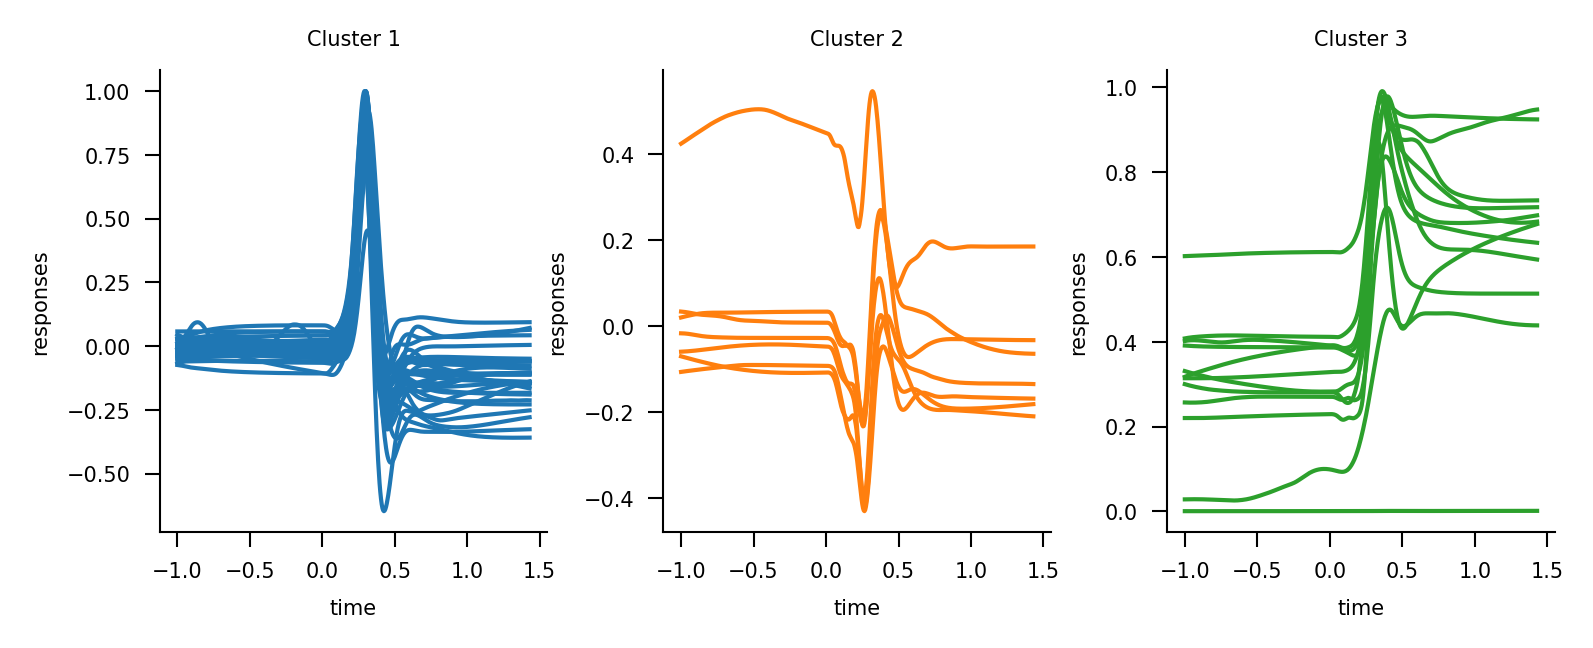

In [30]:
fig, axes = plt.subplots(1, len(cluster_to_indices), figsize=(6, 2))
colors = {i: color for i, color in enumerate(mcolors.TABLEAU_COLORS.values())}
for cluster_id, indices in cluster_to_indices.items():
    stims_and_resps_moving_edge['responses'].sel(network_id=indices).custom.where(
        cell_type="T4c", intensity=1, speed=19, angle=90
    ).custom.plot_traces(
        x="time",
        plot_kwargs=dict(color=colors[cluster_id], add_legend=False, ax=axes[cluster_id]),
    )
    axes[cluster_id].set_title(f"Cluster {cluster_id + 1}")
plt.subplots_adjust(wspace=0.3)

(<Figure size 300x300 with 1 Axes>, <PolarAxes: >)

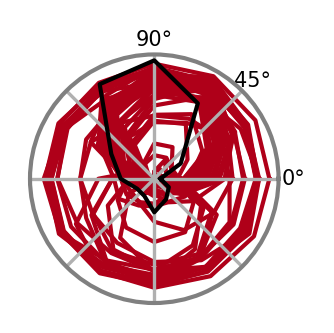

In [31]:
plot_angular_tuning(
    stims_and_resps_moving_edge,
    "T4c",
    intensity=1,
)

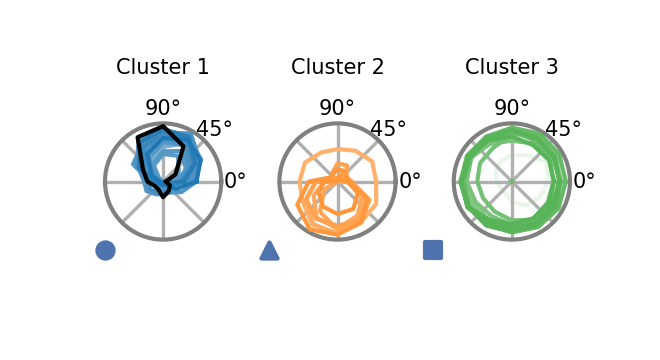

In [32]:
tabcolors = list(mcolors.TABLEAU_COLORS.values())
colors = [
    ensemble.task_error(cmap=color_to_cmap(tabcolors[cluster_id]).reversed()).colors[
        indices
    ]
    for cluster_id, indices in cluster_to_indices.items()
]
fig, axes = plt.subplots(
    1, len(cluster_to_indices), subplot_kw={"projection": "polar"}, figsize=[2, 1]
)
for cluster_id, indices in cluster_to_indices.items():
    plot_angular_tuning(
        stims_and_resps_moving_edge.sel(network_id=indices),
        "T4c",
        intensity=1,
        colors=colors[cluster_id],
        zorder=ensemble.zorder()[indices],
        groundtruth=True if cluster_id == 0 else False,
        fig=fig,
        ax=axes[cluster_id],
    )
    plt_utils.add_cluster_marker(
        fig, axes[cluster_id], marker=plt_utils.get_marker(cluster_id)
    )
    axes[cluster_id].set_title(f"Cluster {cluster_id + 1}")
plt.subplots_adjust(wspace=0.5)

As we can see here, the models predict clustered neural responses.

# Load precomputed umap and clustering

Due to the computational requirement of recording and embedding all responses and for consistency we also show how to use the precomputed embeddings and clusterings from the paper.

In [33]:
cell_type = "T4c"
clustering = ensemble.clustering(cell_type)

[2024-12-08 19:38:15] clustering:835 Loaded T4c embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering


In [34]:
task_error = ensemble.task_error()

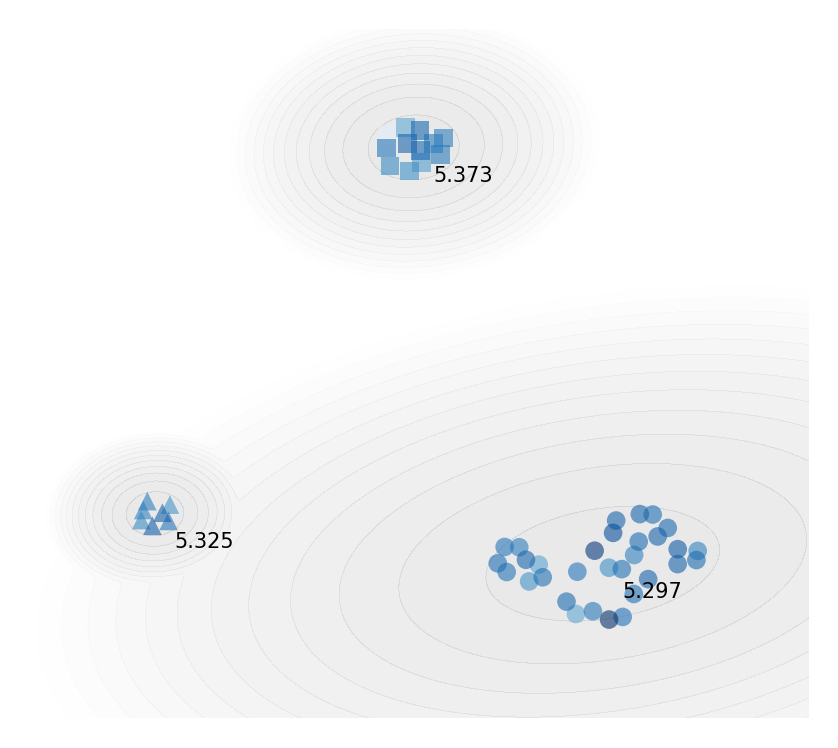

In [35]:
embeddingplot = clustering.plot(task_error=task_error.values, colors=task_error.colors)

With this embedding and clustering one can proceed in the same way as above to plot the tunings.